In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotting
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
import datapreprocessing as dp

# Plots 

In [2]:
def parameter_plot(df, model='', parameter=''):
    fig = plt.figure()
    ax = sns.scatterplot(df.T.groupby('best_param').count().index.values , df.T.groupby('best_param').count()['mean_test_r2'])
    print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                    round(np.std(df.loc['best_param']),4)))
    ax.axhline(0)
    ax.set_title(model+': Parameter Distribution across all targets')
    ax.set_xlabel(parameter)
    return fig

In [3]:
def cv_plot(df, model='', parameter='', score='mean_test_r2'):
    fig = plt.figure()
    for t in df.columns.get_level_values(0).drop_duplicates():
        ax = sns.lineplot(x=df[t].params, y=df[t][score])
    
    # figure out how to print best param. / average out. 
    #print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                    #np.std(df.loc['best_param'])))
    ax.set_title('Parameter Distribution: '+model+parameter)
    ax.set_xlabel(parameter)
    return fig

In [4]:
# looking at one CV case
def cv_single(df, score, best_param, name, param='param_alpha'):
    fig = plt.figure()
    splits = [col for col in df.columns if (score in col) & ('split' in col)]
    plt.plot(df[param],df[splits])
    plt.plot(df[param],df['mean_'+score], label='mean', c = 'black')
    plt.axvline(best_param, linestyle='--', color='k',
                label='CV estimate: alpha='+str(best_param))
    plt.legend()
    plt.xlabel('alpha')
    plt.ylabel(score)
    plt.title(name+' CV')
    return fig

In [5]:
def parameter_r2_plot(df, model='', parameter='', feature='best_param'):
    fig = plt.figure()
    ax = sns.scatterplot(x = df.loc[feature], y=df.loc['mean_test_r2'])
    ax.set_title('{}: R2 value against best {} for all targets'.format(model, parameter))
    ax.set_xlabel(parameter)
    ax.set_ylabel('mean test R2')
    print('Average {}: {} ({})'.format(parameter, np.mean(df.loc[feature]), 
                                    round(np.std(df.loc[feature]), 4)))
    #print('Average R2 for max_depth 30: {}'.format(df.loc[:,df.loc[feature]==30].loc['mean_test_r2'].mean()))
    #print('Average R2 for max_depth 40: {}'.format(df.loc[:,df.loc[feature]==40].loc['mean_test_r2'].mean()))
    return fig

In [115]:
def parameter_r2_violin(df, model='', parameter='', feature='best_param'):
    fig = plt.figure()
    ax = sns.violinplot(x = round(df.loc[feature],5), y=df.loc['mean_test_r2'], scale='width')

    ax.set_title('{}: R2 value against best {} for all targets'.format(model, parameter))
    ax.set_xlabel(parameter)
    ax.set_ylabel('mean test R2')
    
    
    text = [str(n) for n in df.T.groupby(feature).count().iloc[:,0]]
    locs, labels =plt.xticks()

    text = [str(n) for n in df.T.groupby(feature).count().iloc[:,0]]
    top = df.T.groupby(feature).mean_test_r2.max()

    for x,y,t in zip(locs, top, text):

        plt.annotate(t, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,30), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.ylim([-0.1, 1.2])
    print('Average {}: {} ({})'.format(parameter, np.mean(df.loc[feature]), 
                                    round(np.std(df.loc[feature]), 4)))
    #print('Average R2 for max_depth 30: {}'.format(df.loc[:,df.loc[feature]==30].loc['mean_test_r2'].mean()))
    #print('Average R2 for max_depth 40: {}'.format(df.loc[:,df.loc[feature]==40].loc['mean_test_r2'].mean()))
    return fig

In [7]:
def r2_plot(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), 
                      x=df[('Mcm3', parameter)], label='Test R2')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_r2']].mean(axis=1), 
                 x=df[('Mcm3', parameter)], label='Train R2')
    ax.fill_between(df[('Mcm3', parameter)].tolist(), 
                    (df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1) + df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].std(axis=1)).tolist(),
                    (df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1) - df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].std(axis=1)).tolist(), 
                    alpha=0.2) 
    idx = plotting.best_overall_index(df)
    plt.axvline(df[('Mcm3','params')][idx], linestyle='--', color='k',
                label='CV estimate: alpha='+str(round(df[('Mcm3','params')][idx], 4)))
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    return fig

In [8]:
def r2_multi_plot(df, model='', parameter='params'):
    fig = plt.figure()
    plt.plot(df[('Mcm3', parameter)], df[[idx for idx in df.columns if idx[1]=='mean_test_r2']], c='cornflowerblue', alpha=0.1)
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), 
                          x=df[('Mcm3', parameter)], label='Test R2')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_r2']].mean(axis=1), 
                     x=df[('Mcm3', parameter)], label='Train R2')
    idx = plotting.best_overall_index(df)
    plt.axvline(df[('Mcm3','params')][idx], linestyle='--', color='k',
                    label='CV estimate: alpha='+str(round(df[('Mcm3','params')][idx], 4)), alpha=0.6)
    ax.set_title(model+': R2 values across all parameters for all models')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    ax.set_xlim(0.006)
    return fig

In [9]:
def r2_plot_simple(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), x=df[('Mcm3', parameter)], label='Test R2')
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    return fig

In [10]:
def mse_plot_simple(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Test MSE')
    ax.legend()
    ax.set_title(model+': mean MSE values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean MSE value') 
    return fig

In [11]:
def mse_plot(df, model=''):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Test MSE')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Train MSE')
    ax.fill_between(df[('Mcm3', parameter)].tolist(), 
                    (df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1 + df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].std(axis=1)*-1).tolist(),
                    (df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1 - df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].std(axis=1)*-1).tolist(), 
                    alpha=0.2)
    idx = plotting.best_overall_index(df)
    plt.axvline(df[('Mcm3','params')][idx], linestyle='--', color='k',
                label='CV estimate: alpha='+str(round(df[('Mcm3','params')][idx], 4)), alpha=0.6)
    ax.legend()
    ax.set_title(model+': mean MSE values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean MSE value')
    return fig

In [27]:
pred, X, velocity_genes, y = dp.get_data(louvain=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y['louvain'], test_size = 0.25, shuffle=True, random_state=42)

pred, X, velocity_genes, y = dp.get_data(predictors='velocity_genes', louvain=True)
X_train_1109, X_test_1109, y_train_1109, y_test_1109 = train_test_split(X, y, stratify=y['louvain'], test_size = 0.25, shuffle=True, random_state=42)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# Lasso 160

In [3]:
# import models
path = './model_selection/Lasso(random_state=42)/'

lasso, best_lasso = plotting.compile_gridsearches_lin(path)

ldf_160 = pd.DataFrame(plotting.reform(lasso))
best_ldf_160 = pd.DataFrame(best_lasso)

In [117]:
# settings
best = best_ldf_160
full = ldf_160
name = 'Lasso'
parameter = 'params'
model = Lasso()

In [19]:
#coutn how many have optimum as best vlaue. 
best_ldf_160.transpose()[best_ldf_160.transpose()['best_param']<0.0004]

,Tppp3,Nrn1,Abi3,Calcb,Cxxc5,H2-Ab1,H2-Aa,Ifit3,Ahnak,Fam101b,...,Ccnb2,Fxyd5,Cep55,Diaph3,Serbp1,Nap1l1,Rasgrp2,Malat1,Hsp90ab1,S100a6
best_param,0.002906,0.000720,0.000720,0.001446,0.000720,0.000720,0.001446,0.001446,0.000720,0.000720,...,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358
mean_test_r2,0.031025,0.050630,0.051179,0.054903,0.058155,0.067680,0.057670,0.068831,0.070015,0.071005,...,0.713863,0.717354,0.716942,0.727096,0.734981,0.742851,0.771343,0.801745,0.813222,0.817947
mean_train_r2,0.064926,0.078687,0.083401,0.083553,0.087952,0.092649,0.093105,0.093450,0.096400,0.101700,...,0.724858,0.726642,0.727861,0.736913,0.746157,0.754735,0.778860,0.808813,0.820992,0.824304
mean_test_neg_mean_squared_error,0.845712,0.898299,0.972927,0.963402,0.909724,0.832502,0.953068,0.941835,0.945593,0.971941,...,0.281698,0.281250,0.284412,0.271868,0.261208,0.257267,0.227177,0.197940,0.182765,0.181794
mean_train_neg_mean_squared_error,0.829774,0.871176,0.941177,0.938127,0.881573,0.813508,0.929904,0.917234,0.919576,0.941352,...,0.271701,0.272147,0.274620,0.262622,0.251687,0.246892,0.220395,0.191275,0.177014,0.175875
std_test_neg_mean_squared_error,0.417039,0.252373,0.113064,0.231579,0.119525,0.293112,0.399557,0.088800,0.048828,0.115544,...,0.033811,0.017791,0.025914,0.019359,0.011825,0.017707,0.014136,0.009221,0.007936,0.009701
std_train_neg_mean_squared_error,0.044140,0.027111,0.012077,0.024627,0.013150,0.031897,0.042653,0.009562,0.005527,0.012442,...,0.003706,0.001925,0.002737,0.002035,0.001214,0.001878,0.001493,0.001045,0.000884,0.001033
std_test_r2,0.050660,0.013819,0.013667,0.030525,0.015013,0.027511,0.032599,0.017921,0.022585,0.014622,...,0.029976,0.012594,0.024604,0.016354,0.022480,0.025575,0.010251,0.012519,0.018328,0.009393
std_train_r2,0.003885,0.001903,0.001401,0.003900,0.001642,0.003085,0.003594,0.002050,0.002647,0.001579,...,0.003378,0.001421,0.002823,0.001736,0.002283,0.002742,0.001058,0.001342,0.001933,0.001012


In [17]:
ldf_160[[idx for idx in ldf_160.columns if idx[1]=='mean_test_neg_mean_squared_error']][-5:].mean(axis=1)

5   -0.768774
6   -0.754474
7   -0.747874
8   -0.746391
9   -0.746739
dtype: float64

<AxesSubplot:xlabel="('Mcm3', 'params')">

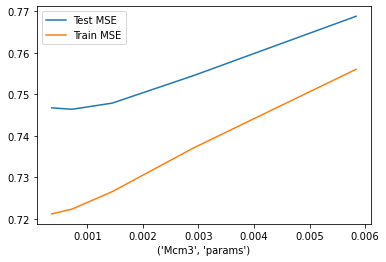

In [18]:
sns.lineplot(y=ldf_160[[idx for idx in ldf_160.columns if idx[1]=='mean_test_neg_mean_squared_error']][-5:].mean(axis=1)*-1, x=ldf_160[('Mcm3', 'params')][-5:], label='Test MSE')
sns.lineplot(y=ldf_160[[idx for idx in ldf_160.columns if idx[1]=='mean_train_neg_mean_squared_error']][-5:].mean(axis=1)*-1, x=ldf_160[('Mcm3', 'params')][-5:], label='Train MSE')

<AxesSubplot:xlabel="('Mcm3', 'params')">

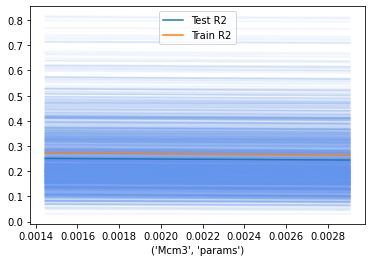

In [19]:
df = ldf_160

plt.plot(df[('Mcm3', parameter)][-4:-2], df[[idx for idx in df.columns if idx[1]=='mean_test_r2']][-4:-2], c='cornflowerblue', alpha=0.1)
ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']][-4:-2].mean(axis=1), 
                          x=df[('Mcm3', parameter)][-4:-2], label='Test R2')
sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_r2']][-4:-2].mean(axis=1), 
                     x=df[('Mcm3', parameter)][-4:-2], label='Train R2')

Average params: 0.0006785662167529306 (0.0002)
Average params: 0.0006785662167529306 (0.0002)


/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Average: 0.0006785662167529306 (0.0002)


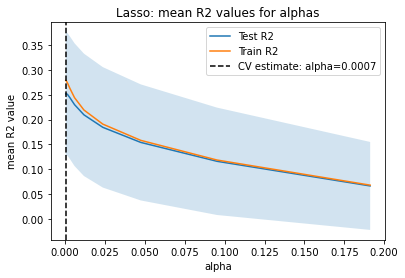

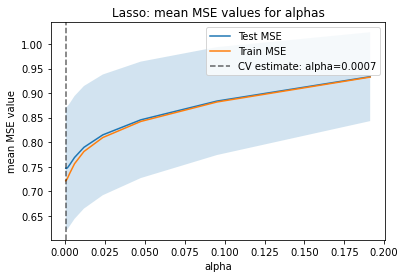

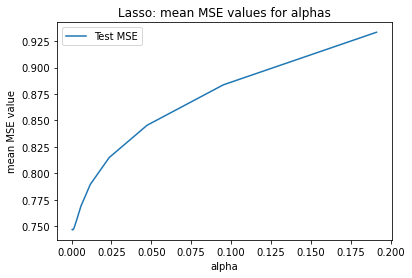

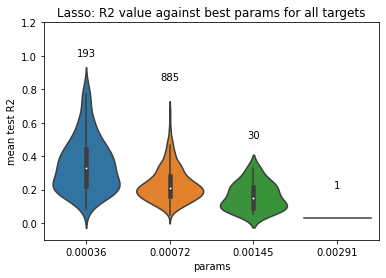

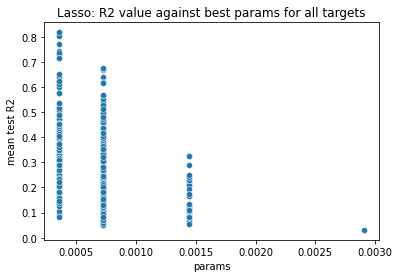

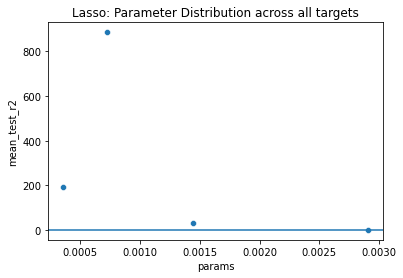

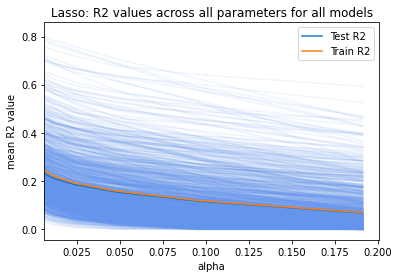

In [118]:
# plots
r2_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_plot.png')
mse_plot(full, model=name).savefig(path+'plots/mse_plot.png')
mse_plot_simple(full, model=name, parameter=parameter).savefig(path+'plots/mse_plot_simple.png')
parameter_r2_violin(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2_violin.png')
parameter_r2_plot(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2.png')
parameter_plot(best, model=name, parameter=parameter).savefig(path+'plots/parameter_plot.png')
r2_multi_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_multi_plot.png')

complete


/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.1015625, tolerance: 1.0156888961791992
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.1334228515625, tolerance: 1.0274980068206787
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382.98992919921875, tolerance: 1.0235763788223267
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

single


/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.1015625, tolerance: 1.0156888961791992
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.1334228515625, tolerance: 1.0274980068206787
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382.98992919921875, tolerance: 1.0235763788223267
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

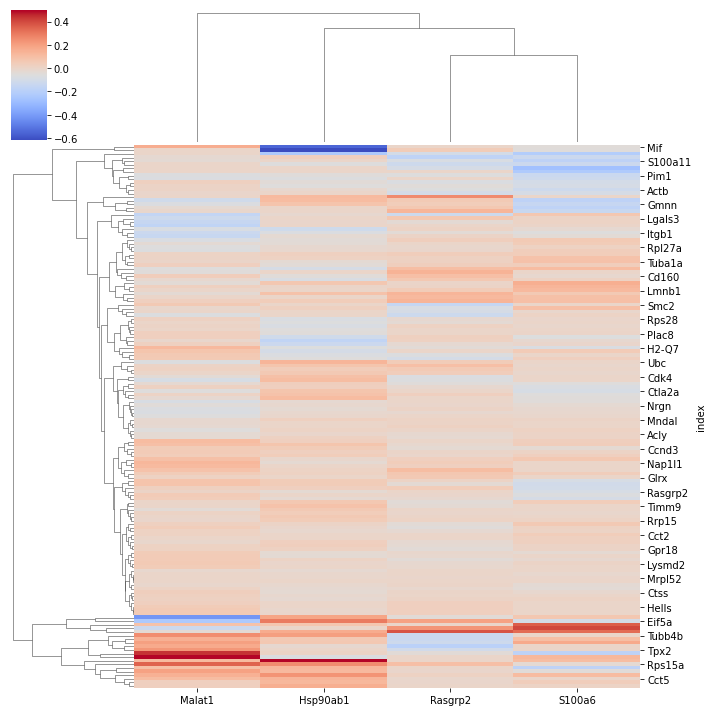

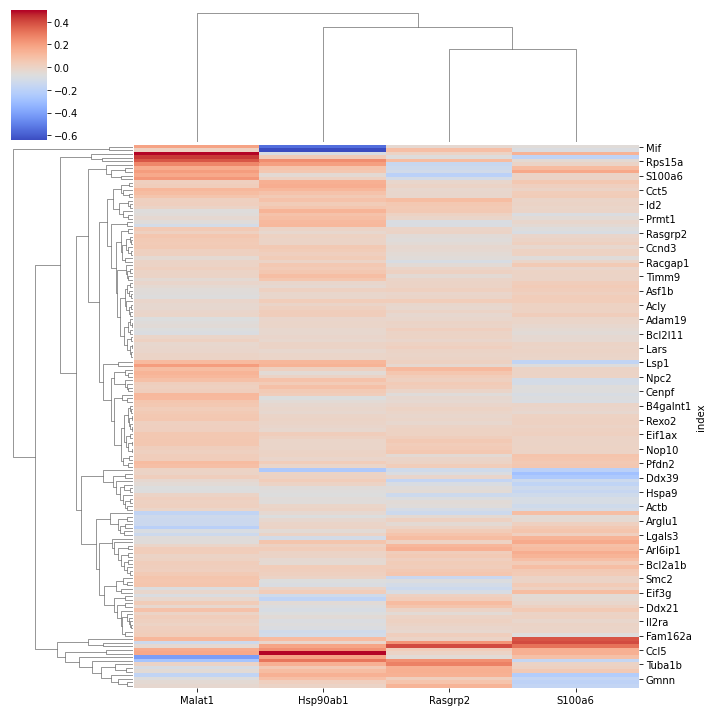

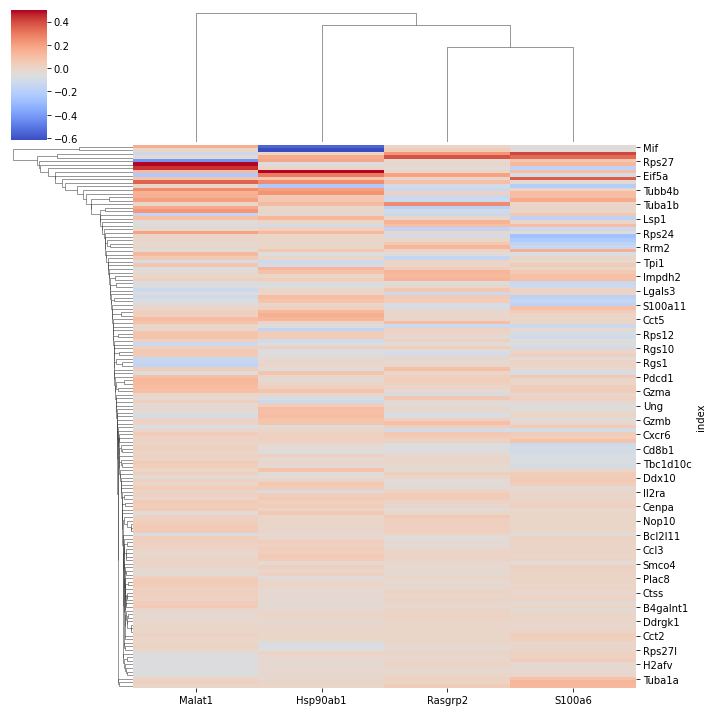

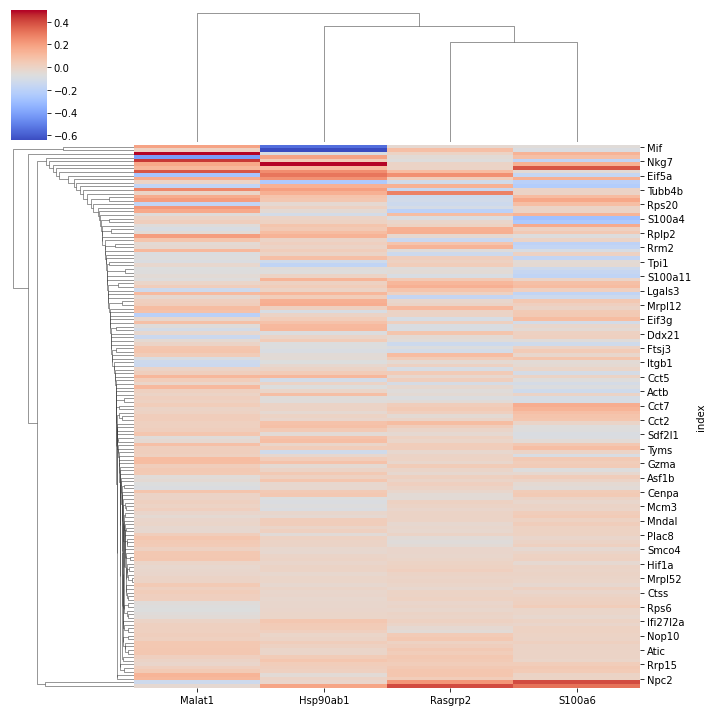

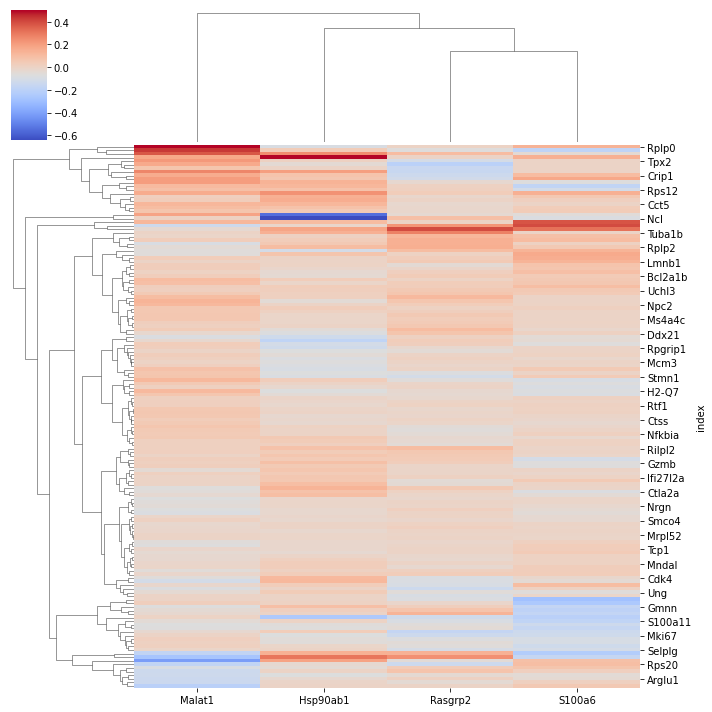

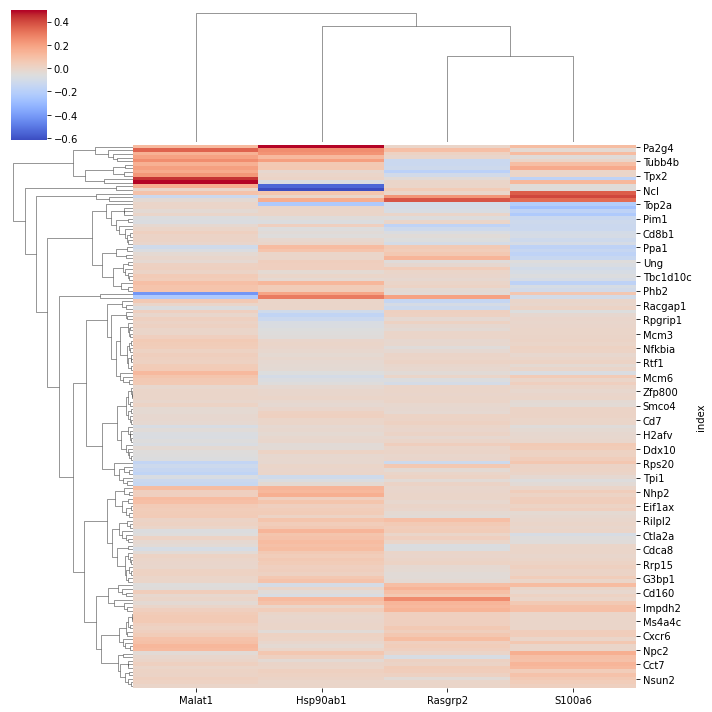

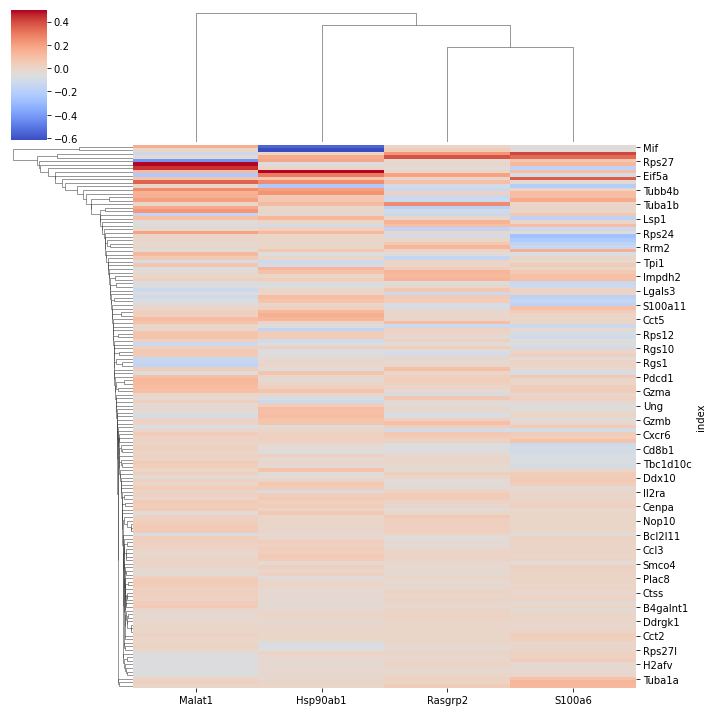

In [21]:
# clustering
print('complete')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/')
plotting.cluster_individual(model, best, X_train, y_train, path+'plots/')
print('single')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='single')
grida = plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='single')

plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='single')

# Lasso 1109

In [22]:
# import models
path = './model_selection/vpred/Lasso(random_state=42)/'

lasso, best_lasso = plotting.compile_gridsearches_lin(path)

ldf_1109 = pd.DataFrame(plotting.reform(lasso))
best_ldf_1109 = pd.DataFrame(best_lasso)

In [23]:
# settings
best = best_ldf_1109
full = ldf_1109
name = 'Lasso'
parameter = 'params'
model = Lasso()

Average params: 0.0014343506943192065 (0.0003)
Average params: 0.0014343506943192065 (0.0003)
Average: 0.0014343506943192065 (0.0003)


/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


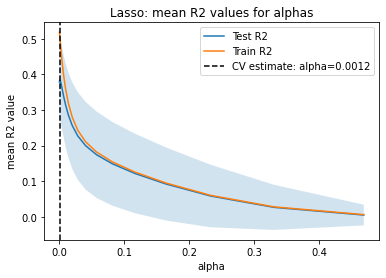

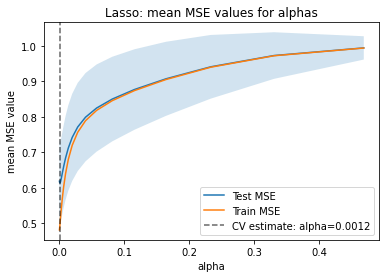

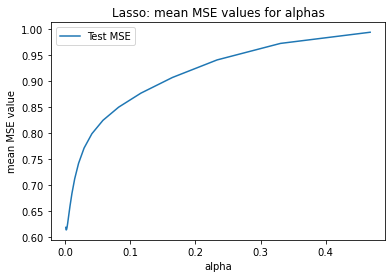

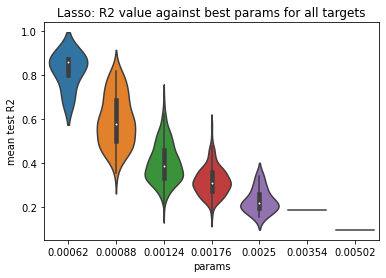

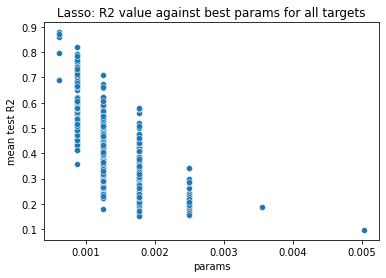

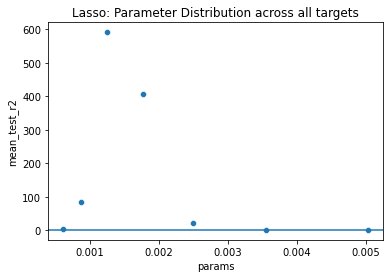

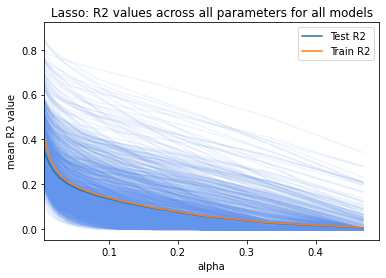

In [24]:
# plots
r2_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_plot.png')
mse_plot(full, model=name).savefig(path+'plots/mse_plot.png')
mse_plot_simple(full, model=name, parameter=parameter).savefig(path+'plots/mse_plot_simple.png')
parameter_r2_violin(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2_violin.png')
parameter_r2_plot(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2.png')
parameter_plot(best, model=name, parameter=parameter).savefig(path+'plots/parameter_plot.png')
r2_multi_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_multi_plot.png')

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300.149658203125, tolerance: 1.0338935852050781
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217.5802001953125, tolerance: 1.0448572635650635
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 417.76434326171875, tolerance: 1.0119308233261108
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 488.128662109375, tolerance: 1.0141894817352295
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.46356201171875, tolerance: 1.0338935852050781
  model = cd_fast.enet_coordinate_descent(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number 

KeyboardInterrupt: 

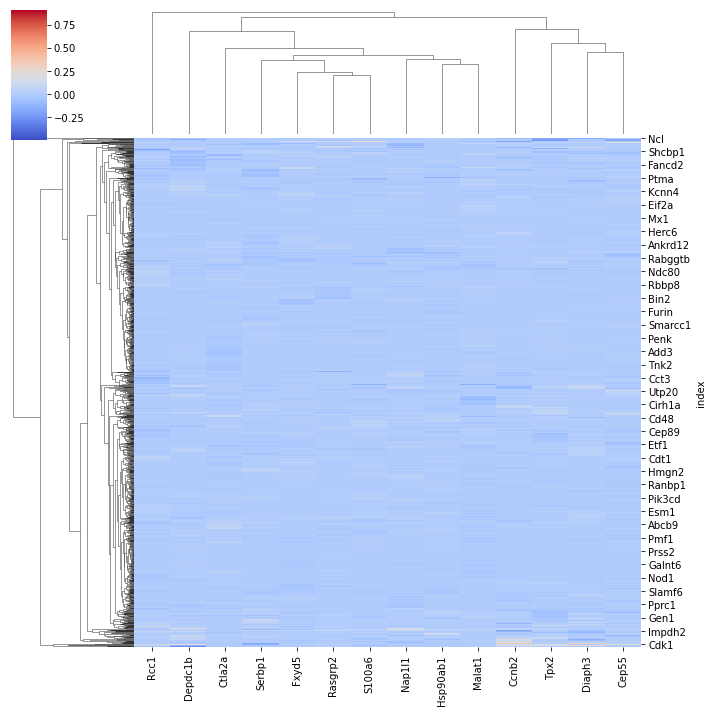

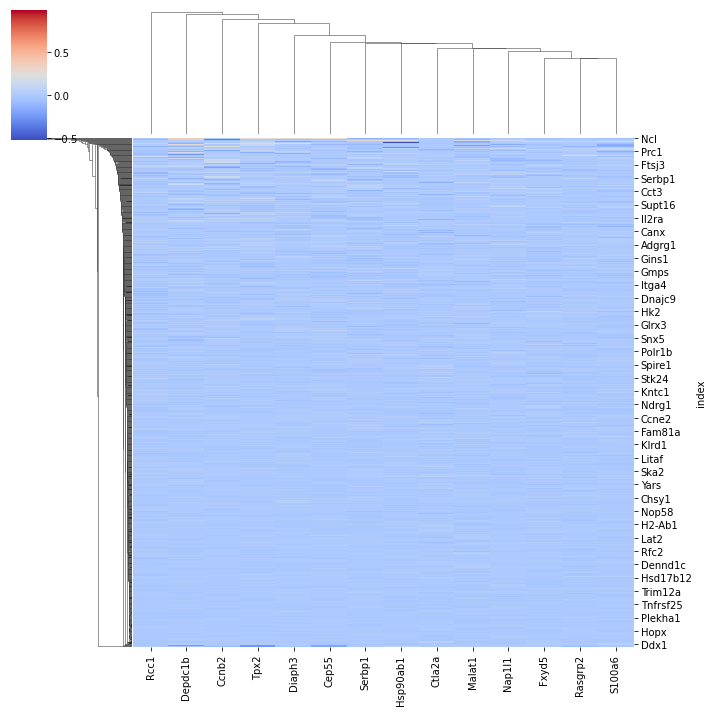

In [25]:
# clustering
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/')
grida = plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='single')
plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/')
plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='single')

# Ridge 160

In [26]:
# import models
path = './model_selection/Ridge(random_state=42)/'

ridge, best_ridge = plotting.compile_gridsearches_lin(path)

rdf_160 = pd.DataFrame(plotting.reform(ridge))
best_rdf_160 = pd.DataFrame(best_ridge)

In [89]:
# settings
best = best_rdf_160
full = rdf_160
name = 'Ridge'
parameter = 'params'
model = Ridge()

In [ ]:
# plots
r2_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_plot.png')
mse_plot(full, model=name).savefig(path+'plots/mse_plot.png')
mse_plot_simple(full, model=name, parameter=parameter).savefig(path+'plots/mse_plot_simple.png')
parameter_r2_violin(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2_violin.png')
parameter_r2_plot(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2.png')
parameter_plot(best, model=name, parameter=parameter).savefig(path+'plots/parameter_plot.png')
r2_multi_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_multi_plot.png')

In [ ]:
# clustering
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/')
grida = plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='single')
plotting.cluster_individual(model, best, X_train, y_train, path+'plots/')
plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train, y_train, path+'plots/', clustering='single')

# Ridge 1109

In [28]:
# import models
path = './model_selection/vpred/Ridge(random_state=42)/'

ridge, best_ridge = plotting.compile_gridsearches_lin(path)

rdf_1109 = pd.DataFrame(plotting.reform(ridge))
best_rdf_1109 = pd.DataFrame(best_ridge)

In [ ]:
# settings
best = best_rdf_1109
full = rdf_1109
name = 'Ridge'
parameter = 'params'
model = Ridge()

In [ ]:
# plots
r2_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_plot.png')
mse_plot(full, model=name).savefig(path+'plots/mse_plot.png')
mse_plot_simple(full, model=name, parameter=parameter).savefig(path+'plots/mse_plot_simple.png')
parameter_r2_violin(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2_violin.png')
parameter_r2_plot(best, model=name, parameter=parameter, feature='best_param').savefig(path+'plots/parameter_r2.png')
parameter_plot(best, model=name, parameter=parameter).savefig(path+'plots/parameter_plot.png')
r2_multi_plot(full, model=name, parameter = parameter).savefig(path+'plots/r2_multi_plot.png')

In [ ]:
# clustering
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/')
grida = plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='single')
plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/')
plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='ward')
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='single')

# Linear 160

In [29]:
# import models
path = './model_selection/LinearRegression()/'

lin, best_lin = plotting.compile_gridsearches_lin(path, lin = True)

lindf_160 = pd.DataFrame(plotting.reform(lin))
best_lindf_160 = pd.DataFrame(best_lin)

In [ ]:
# I dont think plots make sense here. Just to compare. And clusters also do not make sens. nothing here.

In [ ]:
model=LinearRegression()
full = lindf_160
best = best_lindf_160

plotting.cluster_individual(model, best, X_train, y_train, path+'plots/', clustering='ward', lin=True)

In [ ]:
data=lindf_160
index=0

slip = data[[idx for idx in data.columns if idx[1]=='mean_test_neg_mean_squared_error']].iloc[index,:].droplevel(1)
slip[slip>-0.25]

# Linear 1109

In [30]:
# import models
path = './model_selection/vpred/LinearRegression()/'

lin, best_lin = plotting.compile_gridsearches_lin(path, lin = True)

lindf_1109 = pd.DataFrame(plotting.reform(lin))
best_lindf_1109 = pd.DataFrame(best_lin)

In [ ]:
model=LinearRegression()
full = lindf_1109
best = best_lindf_1109

plotting.cluster_individual(model, best, X_train_1109, y_train_1109, path+'plots/', clustering='ward', lin=True)
gridc = plotting.cluster_overall(model, full, X_train_1109, y_train_1109, path+'plots/', clustering='ward', lin=True)

# Random Forest 151


In [119]:
# import models
path = './model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/'

rf, best_rf = plotting.compile_gridsearches_rf(path)

rfdf_151 = pd.DataFrame(plotting.reform(rf))
best_rfdf_151 = pd.DataFrame(best_rf)

Average max features: 75.11541929666366 (54.1567)
Average max depth: 46.88007213706042 (19.3866)


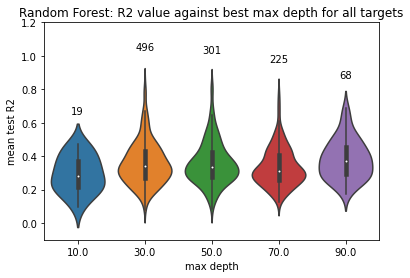

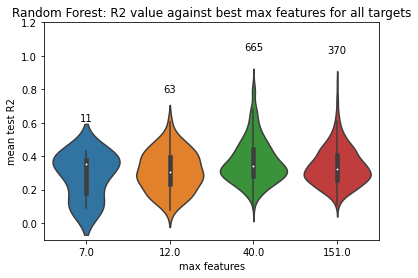

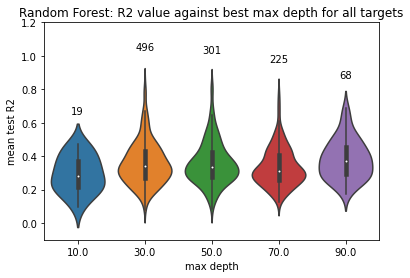

In [120]:
parameter_r2_violin(best_rfdf_151, parameter='max features', feature='features', model='Random Forest')
parameter_r2_violin(best_rfdf_151, parameter='max depth', feature='depth', model='Random Forest')

# Random Forest 1109


In [33]:
# import models
path = './model_selection/vpred/RandomForestRegressor(n_jobs=-1, random_state=42)/'

rf, best_rf = plotting.compile_gridsearches_rf(path, max_features=1109 )

rfdf_1109 = pd.DataFrame(plotting.reform(rf))
best_rfdf_1109 = pd.DataFrame(best_rf)

Average max features: 1065.5220919747521 (211.4148)
Average max depth: 50.46889089269612 (20.747)


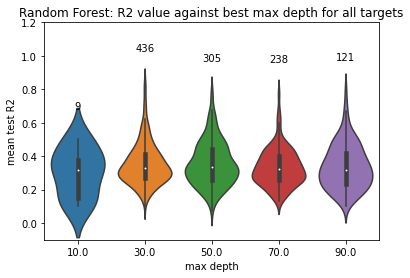

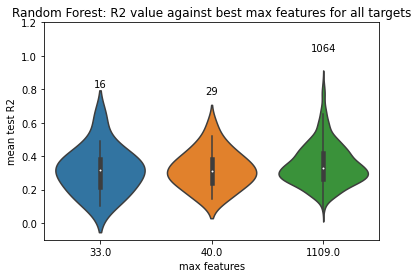

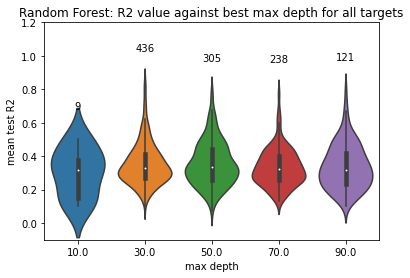

In [121]:
parameter_r2_violin(best_rfdf_1109, parameter='max features', feature='features', model='Random Forest')
parameter_r2_violin(best_rfdf_1109, parameter='max depth', feature='depth', model='Random Forest')

# Table with best R2 and MSE values

In [ ]:
ind = {k:'{} ({})'.format(round(v.loc[evaluate].mean(), 5), round(v.loc[evaluate].std(), 3)) for k, v in data.items()}
ind

In [34]:
evaluate ='mean_test_r2'
d = {'Lasso_151':best_ldf_160, 
    'Lasso_1109':best_ldf_1109, 
    'Ridge_151':best_rdf_160, 
    'Ridge_1109':best_rdf_1109,
    'Linear_151': best_lindf_160,
    'Linear_1109': best_lindf_1109,
    'Random_Forest_151':best_rfdf_151,
    'Random_Forest_1109':best_rfdf_1109}


ind = {k:'{} ({})'.format(round(v.loc[evaluate].mean(), 5), round(v.loc[evaluate].std(), 3)) for k, v in d.items()}
average = {k:'{} ({})'.format(round(v[[idx for idx in v.columns if idx[1]==evaluate]].iloc[plotting.best_overall_index(v),:].droplevel(1).mean(), 5), 
                              round(v[[idx for idx in v.columns if idx[1]==evaluate]].iloc[plotting.best_overall_index(v),:].droplevel(1).std(), 3))
           for k, v in {'Lasso_151':ldf_160, 'Lasso_1109':ldf_1109, 'Ridge_151':rdf_160, 'Ridge_1109':rdf_1109, 'Random_Forest_151':rfdf_151, 'Random_Forest_1109':rfdf_1109}.items()}

parameter = {k:'{}'.format(round(v.loc[plotting.best_overall_index(v),('Mcm3', 'params')],4)) 
             for k, v in {'Lasso_151':ldf_160, 'Lasso_1109':ldf_1109, 'Ridge_151':rdf_160, 'Ridge_1109':rdf_1109}.items()}
parameter['Random_Forest_151']='max_depth: {}, max_features: {}'.format(rfdf_151.iloc[plotting.best_overall_index(rfdf_151)].droplevel(0)['depth'][0], 
                                                                        rfdf_151.iloc[plotting.best_overall_index(rfdf_151)].droplevel(0)['features'][0])
parameter['Random_Forest_1109']='max_depth: {}, max_features: {}'.format(rfdf_1109.iloc[plotting.best_overall_index(rfdf_1109)].droplevel(0)['depth'][0], 
                                                                        rfdf_1109.iloc[plotting.best_overall_index(rfdf_1109)].droplevel(0)['features'][0])



results = pd.DataFrame({'individual': ind, 'average': average, 'parameter': parameter})
# results

,individual,average,parameter
Lasso_151,0.25236 (0.124),0.25231 (0.124),0.0007
Lasso_1109,0.38419 (0.116),0.38366 (0.116),0.0012
Ridge_151,0.25749 (0.131),0.2573 (0.131),35
Ridge_1109,0.38652 (0.114),0.38591 (0.115),400
Linear_151,0.25146 (0.125),NaN,NaN
Linear_1109,0.36424 (0.121),NaN,NaN
Random_Forest_151,0.35404 (0.126),0.34726 (0.128),"max_depth: 30, max_features: 40"
Random_Forest_1109,0.34866 (0.125),0.34561 (0.127),"max_depth: 50, max_features: 1109"


In [29]:
# R2 Test error of best model tested on holdout data set. 

ridge = Ridge(alpha=35, random_state=42)
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.2630855062084079

In [31]:


ind = {k:'{} ({})'.format(v.loc['mean_train_r2'].mean(), round(v.loc['mean_train_r2'].std(), 3)) for k, v in {'Lasso_151':best_ldf_160, 'Lasso_1109':best_ldf_1109, 'Ridge_151':best_rdf_160, 'Ridge_1109':best_rdf_1109}.items()}
average = {k:v[[idx for idx in v.columns if idx[1]=='mean_train_r2']].iloc[plotting.best_overall_index(v),:].droplevel(1).mean() for k, v in {'Lasso_151':ldf_160, 'Lasso_1109':ldf_1109, 'Ridge_151':rdf_160, 'Ridge_1109':rdf_1109}.items()}


results = pd.DataFrame({'individual': ind, 'average': average})
results

NameError: name 'best_ldf_1109' is not defined

In [32]:


ind = {k:v.loc['mean_test_neg_mean_squared_error'].mean() for k, v in {'Lasso_151':best_ldf_160, 'Lasso_1109':best_ldf_1109, 'Ridge_151':best_rdf_160, 'Ridge_1109':best_rdf_1109}.items()}
average = {k:v[[idx for idx in v.columns if idx[1]=='mean_test_neg_mean_squared_error']].iloc[plotting.best_overall_index(v),:].droplevel(1).mean() for k, v in {'Lasso_151':ldf_160, 'Lasso_1109':ldf_1109, 'Ridge_151':rdf_160, 'Ridge_1109':rdf_1109}.items()}


results = pd.DataFrame({'individual': ind, 'average': average})
results

NameError: name 'best_ldf_1109' is not defined